In [19]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
import scipy.io

In [20]:
# Load the .mat file
data = scipy.io.loadmat('/Users/nickgravina/Dropbox/NGravina/RuntSyntetics/data.mat')
TFinput = scipy.io.loadmat('/Users/nickgravina/Dropbox/NGravina/RuntSyntetics/TFinput.mat')

# Access the Rate variables
data = data['data']
construct_index = 4
#data_type = 'Rate_WT_individual'
print(data[0][construct_index]['constructName'][0])

Rate_WT_mean = np.nanmean(data[0][construct_index]['Rate_WT_individual'], axis=1);
Rate_WT_std = np.nanstd(data[0][construct_index]['Rate_WT_individual'], axis=1);
N_WT = data[0][construct_index]['Rate_WT_individual'].shape[1]

Rate_null_mean = np.nanmean(data[0][construct_index]['Rate_null_individual'], axis=1);
Rate_null_std = np.nanstd(data[0][construct_index]['Rate_null_individual'], axis=1);
N_null = data[0][construct_index]['Rate_null_individual'].shape[1]

APbins = data[0][construct_index]['APbins']

# Access the Transcription Factor inputs
TFinput = TFinput['TFinput']
Bcd = TFinput[:,0]
Runt = TFinput[:,1]
Runt_Null = TFinput[:,2]

### Remove NaN Data points ###
# Truncate APbins to user-specified range
NoNaN_index_null = ~np.isnan(Rate_null_mean)
NoNaN_index_WT = ~np.isnan(Rate_WT_mean)
NoNaN_index_Bcd = ~np.isnan(Bcd)
NoNaN_index_Runt = ~np.isnan(Runt)
# calculate the AP bins that are not NaNs in both WT and Null datasets
NoNaN_index = NoNaN_index_null * NoNaN_index_WT * NoNaN_index_Bcd * NoNaN_index_Runt

NoNaNindices = np.where(NoNaN_index)[0]

# Truncate the vectors using the range of AP bins
APbins= np.take(APbins, NoNaNindices)
Rate_WT_mean = np.take(Rate_WT_mean, NoNaNindices)
Rate_WT_std = np.take(Rate_WT_std, NoNaNindices)
Rate_WT_err = Rate_WT_std/np.sqrt(N_WT)

Rate_null_mean = np.take(Rate_null_mean, NoNaNindices)
Rate_null_std = np.take(Rate_null_std, NoNaNindices)
Rate_null_err = Rate_WT_std/np.sqrt(N_null)

Bcd = np.take (Bcd, NoNaNindices)
Runt = np.take (Runt, NoNaNindices)
Runt_Null = np.take(Runt_Null, NoNaNindices)

r1-close


/var/folders/_r/s5340_w11gldx7_0mf4g4bpw0000gn/T/ipykernel_3055/3372155012.py:11: RuntimeWarning: Mean of empty slice
  Rate_WT_mean = np.nanmean(data[0][construct_index]['Rate_WT_individual'], axis=1);
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/_r/s5340_w11gldx7_0mf4g4bpw0000gn/T/ipykernel_3055/3372155012.py:15: RuntimeWarning: Mean of empty slice
  Rate_null_mean = np.nanmean(data[0][construct_index]['Rate_null_individual'], axis=1);


In [21]:
# Define the model function
def model_1bs(theta, theta_fixed, Bcd, Runt):
    logK_r, w_rp = theta
    R, p, K_b, w_bp = theta_fixed
    b = Bcd/K_b
    r = Runt/(10**logK_r)
    Z = 1 + (b**6) + r + r*(b**6) + p + (b**6)*p*w_bp+ r*p*w_rp + r*(b**6)*p*w_bp*w_rp
    return R*((p + (b**6)*p*w_bp+ r*p*w_rp + r*(b**6)*p*w_bp*w_rp)/Z)

def model_1bs_null(theta, theta_fixed, Bcd, Runt):
    R, p, K_b, w_bp = theta
    b = Bcd/K_b
    Z = 1 + (b**6) + p + (b**6)*p*w_bp
    return R*((p + (b**6)*p*w_bp)/Z)


# Define the log-likelihood function
# def log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate, Rate_err):
#     model_Rate = model(theta, theta_fixed, Bcd, Runt)
#     sigma2 = Rate_err ** 2
#     return -0.5 * np.sum(((Rate - model_Rate)**2)/sigma2 + np.log(sigma2))
# Defin the log-likehood function
def log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate, Rate_err):
    model_Rate = model(theta, theta_fixed, Bcd, Runt)
    sigma2 = Rate_err ** 2
    return -0.5 * np.sum(((Rate - model_Rate)**2))

# Define the log-prior function
def log_prior_1bs_null(theta):
    R, p, K_b, w_bp = theta
    if (50 < R < 419) and (0.0001 < p < 0.4) and (60 < K_b < 90) and (20 < w_bp < 90):
        return 0.0
    else:
        return -np.inf
def log_prior_1bs(theta):
    logK_r, w_rp = theta
    if (-0.5 < logK_r < 1) and (0 < w_rp < 1.2):
        return 0.0
    else:
        return -np.inf

# Define the log-posterior function
def log_posterior_1bs_null(theta, model, theta_fixed, Bcd, Runt, Rate, Rate_err):
    lp = log_prior_1bs_null(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate, Rate_err)
def log_posterior_1bs(theta, model, theta_fixed, Bcd, Runt, Rate, Rate_err):
    lp = log_prior_1bs(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, model, theta_fixed, Bcd, Runt, Rate, Rate_err)

In [22]:
####  Runt Null Fits ####
# Set up the sampler
ndim = 4
nwalkers = 200
theta0 = [100, 0.1, 70, 60] #original theta0 from looking at files
#theta0 = [350, 0.1, 70, 60]

# R, p, K_b, w_bp, K_r, w_rp
cov = np.diag([1, 0.01, 0.1, 1]) # Covariance matrix
move = emcee.moves.GaussianMove(cov)

pos = [theta0 + [1, 0.01, 0.1, 1]*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1bs_null, 
                                args=(model_1bs_null, [], Bcd, Runt, Rate_null_mean, Rate_null_err))

# Burn-in phase
pos, _, _ = sampler.run_mcmc(pos, 10000)

# Production phase
for i in range(1):
    sampler.reset()
    sampler.run_mcmc(pos, 20000)

    # Extract the samples
    samples = sampler.get_chain(flat=True)
    
    theta0 = np.mean(samples, axis=0)
    theta0_CI = np.percentile(samples, [2.5, 97.5], axis=0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

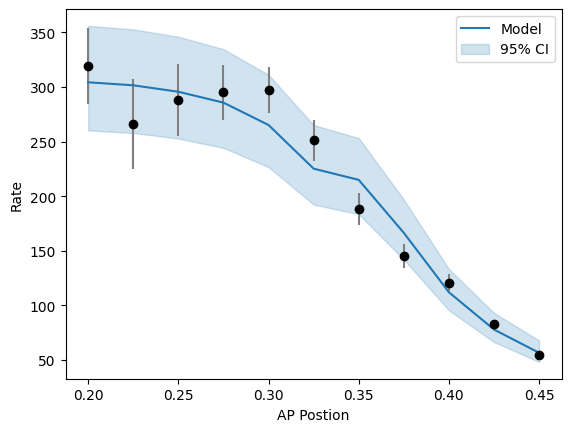

R = 348.2863008900962,  p = 0.12148545109279142,  K_b = 66.61450059490392,  w_bp = 61.92216940360378


In [23]:
# Plot the data 
fig, ax = plt.subplots()
ax.errorbar(APbins, Rate_null_mean, yerr=Rate_null_err, fmt='o', color='k', ecolor='gray', capsize=0)

# Plot model 
theta_nullParams = np.median(samples, axis=0)
Rate_fit = model_1bs_null(theta_nullParams, [], Bcd, Runt)
ax.plot(APbins, Rate_fit, color='C0', label='Model')

# Plot 95% confidence interval
Rate_fit_lower = model_1bs_null(theta0_CI[0,:], [], Bcd, Runt)
Rate_fit_upper = model_1bs_null(theta0_CI[1,:], [], Bcd, Runt)
ax.fill_between(APbins, Rate_fit_lower, Rate_fit_upper, color="C0", alpha=0.2, label="95% CI")
ax.set_xlabel('AP Postion')
ax.set_ylabel('Rate')
plt.legend()
plt.show()


# Print the results
print('R = ' + str(theta_nullParams[0]) + ', ', 'p = ' + str(theta_nullParams[1]) + ', ', 'K_b = ' + str(theta_nullParams[2]) + ', ', 
      'w_bp = ' + str(theta_nullParams[3]))

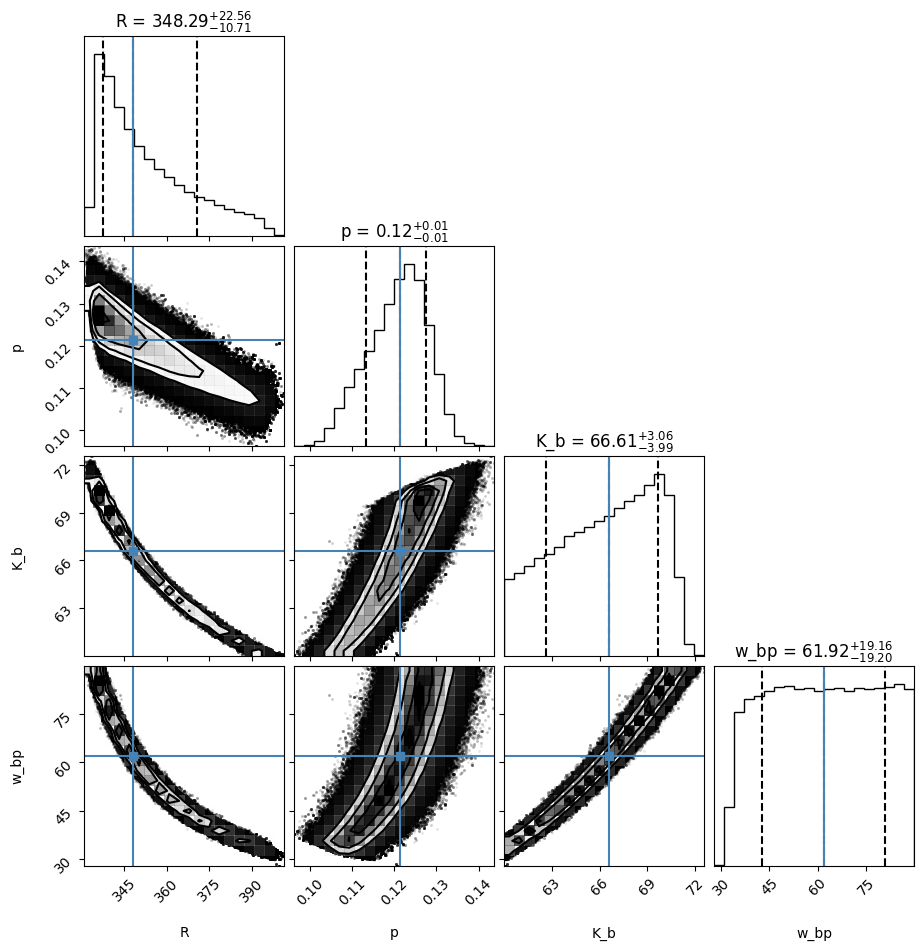

In [24]:
# Plot the corner plot
labels = ['R', 'p', 'K_b', 'w_bp']
fig = corner.corner(samples, labels=labels, truths=theta_nullParams, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

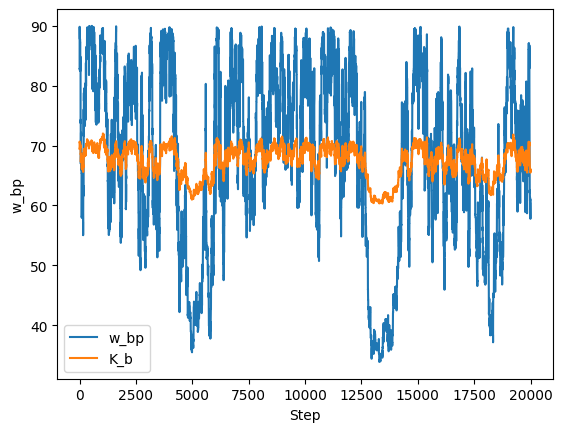

In [25]:
# Plot single w_bp walker
fig, ax = plt.subplots()
ax.plot(sampler.chain[0,:,3], label='w_bp')
ax.plot(sampler.chain[0,:,2], label='K_b')
ax.set_xlabel('Step')
ax.set_ylabel('w_bp')
plt.legend()
plt.show()

In [26]:
#### Runt WT fit using Runt Null parameters ####
# Set up the sampler
ndim = 2
nwalkers = 200
theta0 = [0, 0.5]
theta_fixed = theta_nullParams # Get Runt Null paremeters from previous cell

# R, p, K_b, w_bp, K_r, w_rp
cov = np.diag([100, 10])**2 # Covariance matrix
move = emcee.moves.GaussianMove(cov)

pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_1bs, 
                                args=(model_1bs, theta_fixed, Bcd, Runt, Rate_WT_mean, Rate_WT_err))

# Burn-in phase
pos, _, _ = sampler.run_mcmc(pos, 10000)

# Production phase
for i in range(1):
    sampler.reset()
    sampler.run_mcmc(pos, 20000)

    # Extract the samples
    samples = sampler.get_chain(flat=True)
    
    theta0 = np.mean(samples, axis=0)
    theta0_CI = np.percentile(samples, [2.5, 97.5], axis=0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

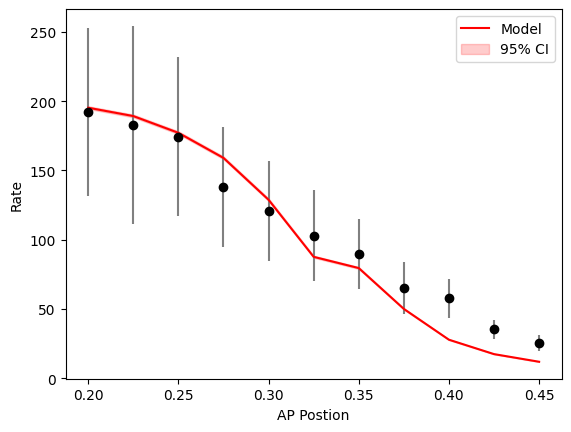

R = 348.2863008900962,  p = 0.12148545109279142,  K_b = 66.61450059490392,  w_bp = 61.92216940360378, logK_r = -0.4689021532089983,  w_rp = 0.1822604206013743


In [27]:
# Plot the data
fig, ax = plt.subplots()
ax.errorbar(APbins, Rate_WT_mean, yerr=Rate_WT_std, fmt='o', color='k', ecolor='gray', capsize=0)

# Plot the model 
theta_WTParams = np.median(samples, axis=0)
Rate_fit = model_1bs(theta_WTParams, theta_nullParams, Bcd, Runt)
ax.plot(APbins, Rate_fit, color='red', label='Model')

# Plot 95% confidence interval
Rate_fit_lower = model_1bs(theta0_CI[0,:], theta_nullParams, Bcd, Runt)
Rate_fit_upper = model_1bs(theta0_CI[1,:], theta_nullParams, Bcd, Runt)
ax.fill_between(APbins, Rate_fit_lower, Rate_fit_upper, color='red', alpha=0.2, label='95% CI')
ax.set_xlabel('AP Postion')
ax.set_ylabel('Rate')
plt.legend()
plt.show()

print('R = ' + str(theta_nullParams[0]) + ', ', 'p = ' + str(theta_nullParams[1]) + ', ', 'K_b = ' + str(theta_nullParams[2]) + ', ', 
      'w_bp = ' + str(theta_nullParams[3])+ ',', 'logK_r = ' + str(theta_WTParams[0]) + ', ', 'w_rp = ' + str(theta_WTParams[1]))

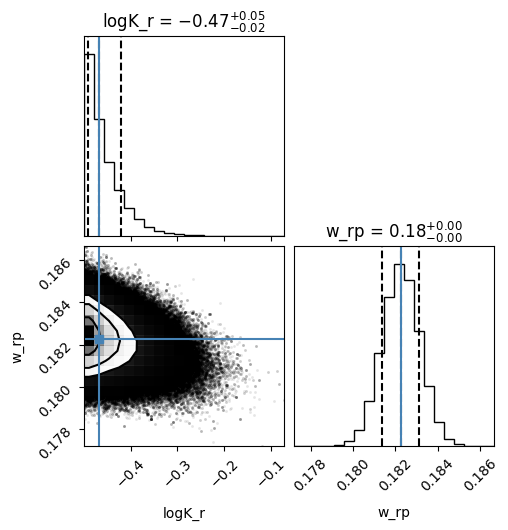

In [28]:
# Plot the corner plot with Runt WT parameters shown as lines
labels = ['logK_r', 'w_rp']
fig = corner.corner(samples, labels=labels, truths=theta_WTParams, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

# labels = ['K_r', 'w_rp']
# fig = corner.corner(samples, labels=labels)
# plt.show()

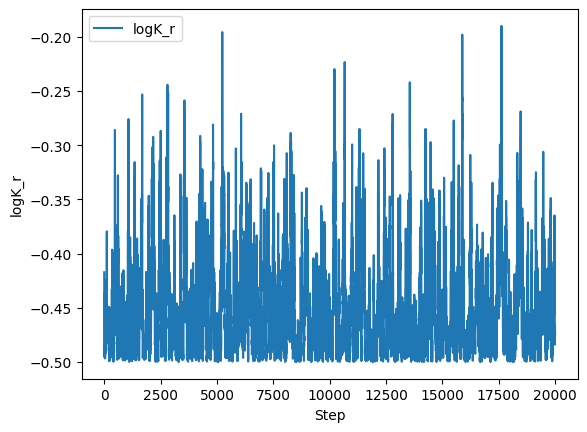

In [29]:
# Plot single logK_r walker
fig, ax = plt.subplots()
ax.plot(sampler.chain[0,:,0],label='logK_r')
#ax.plot(sampler.chain[0,:,1], label='w_rp')
ax.set_xlabel('Step')
ax.set_ylabel('logK_r')
plt.legend()
plt.show()